# 0 Импорты и библиотеки

## import

In [1]:
from dotenv import dotenv_values
from pathlib import Path
from pprint import pprint, pformat
import zipfile

import opendatasets as od 
import pandas as pd
import pandas.api.types as pd_types

import numpy as np

import plotly.express as plotly_px
import plotly.graph_objects as plotly_go
import plotly.subplots as plotly_subplt
import seaborn as sns
import matplotlib.pyplot as plt

import copy
import joblib

from dataclasses import dataclass
import builtins
from pathlib import Path
import time
import tqdm
import abc

In [2]:
from sklearn.model_selection import (
    train_test_split,  # Функция для разделения данных на обучающую и тестовую выборки
    cross_val_score, # оценщик кросс-валидации
    GridSearchCV,  # Класс для поиска гиперпараметров с помощью сеточного поиска
    RandomizedSearchCV
)

from sklearn.preprocessing import (OneHotEncoder, 
                                   OrdinalEncoder
                                  )





## Библиотека

### BaseLib

In [3]:
class BaseLib():
    @staticmethod
    def st():
        """старт таймера"""
        return time.monotonic_ns()
    @staticmethod
    def ft(start):
        """финиш таймера и вывод времени"""
        duration = (time.monotonic_ns() - start) / 1000000000
        print(f'Затрачено времени: {duration:.2f} секунд')
        return duration

    @staticmethod
    def get_type(type_name):
        try:
            return getattr(builtins, type_name)
        except AttributeError:
            try:
                obj = globals()[type_name]
            except KeyError:
                return None
            return repr(obj) if isinstance(obj, type) else None

### DataSetLib

In [4]:
class DataSetLib():
    """Библиотека функций для работы с датасетом"""

    @staticmethod
    def columns_by_type(df, target_name, cat_treshold=2):
        """Сфромировать словарь, с разделением имен столбцов по типам:
        - target_columns - целевой столбец
        - columns_X - все столбцы-фичи
        - num_columns - числовые столбцы
        - cat_columns - категориальные. Категориальными считаютс и числовые столбцы, в которых уникальных значений меньше или равно  cat_treshold"""
        params = {}
        # columns_X - переменные датасета
        params["columns_X"] = df.columns.to_list()
        # целевой столбец
        params["target_column"] = target_name
        if target_name is not None:
            params["columns_X"].remove(params["target_column"])
        params["num_columns"] = []
        params["cat_columns"] = []
        # определить числовые и категориальные столбцы
        for col in params["columns_X"]:
            if df[col].nunique() <= cat_treshold or not pd_types.is_numeric_dtype(df[col]):
                params["cat_columns"].append(col)
            else:
                params["num_columns"].append(col)
        #print(f'target_columns={params["target_column"]}')        
        #print(f'columns_X={params["columns_X"]}')
        #print(f'cat_columns={pformat(params["cat_columns"])}')
        #print(f'num_columns={pformat(params["num_columns"])}')
        return params
    
    @staticmethod
    def remove_columns(params, column): 
        """удалить столбец и словаря параметров"""
        if column in params["columns_X"]:
            params["columns_X"].remove(column)
        if column in params["num_columns"]:
            params["num_columns"].remove(column)
        if column in params["cat_columns"]:
            params["cat_columns"].remove(column)
        return params

    @staticmethod
    def add_columns(params, column, type_column): 
        """добавить столбец в словарь параметров
        type_column = "cat" или "num" или None """
        if column not in params["columns_X"]:
            params["columns_X"].append(column)
        if type_column is None:
            pass
        elif type_column == "cat":
            params["cat_columns"].append(column)
        elif type_column == "num":
            params["num_columns"].append(column)
        else:
            raise ValueError("type_column должен быть 'cat' или 'num'")
        return params

    @staticmethod
    def describe_columns(df, params):
        """Отобразить описание содержимого столбцов"""    
        # подсчет столбцов с пропусками
        nan_in_columns = DataSetLib.nans_percents(df)
        
        print("Количество уникальных значений по столбцам, доля пропусков и уникальные значения, если их не более 10")
        nunique = df[params["columns_X"]].nunique()
        for column in nunique.index:
            if column in params["cat_columns"]:
                column_type = "[c]" # категориальные
            else:
                column_type = "[n]" # числовые
                
            if nan_in_columns[column] > 0:
                nan_str = f'({nan_in_columns[column]:4.1f}%)'
            else:
                nan_str = " "*7
            if nunique[column] <= 10:
                print(f'{column:20}{column_type}: {nunique[column]:6} {nan_str}, {df[column].unique().tolist()}')
            else:
                print(f'{column:20}{column_type}: {nunique[column]:6} {nan_str}')

        if params["target_column"] is not None:
            df_describe_num = DataSetLib.eda_df(df[params["num_columns"]+[params["target_column"]]])
        else:
            df_describe_num = DataSetLib.eda_df(df[params["num_columns"]])
        display(df_describe_num)            

        df_describe_cat = df[params["cat_columns"]].describe()
        display(df_describe_cat)

    @staticmethod
    def eda_df(df):
        """Провести EDA для датафрейма"""
        df_describe = df.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
        # посчитать долю пропусков
        df_describe.loc["%nan"] = (np.round(df[df_describe.columns].isna().mean()*100, 2)).to_list()
        # посчитать дисперсию
        columns_var = []
        for column in df_describe.columns:
            columns_var.append(df[column].var())
        df_describe.loc['var'] = columns_var
        return df_describe

    @staticmethod
    def show_boxes(df, columns, ncols = 3, type="box", row_height=500, total_width=1200):
        """Показать 'ящики_с_усами' для набора df.
        Ящики будут показаны для столбцов датафрема, перечисленных в columns.
        Графики будут показаны в несколько столбцов, количество которых задается в параметре ncols."""
        nrows = int(round((len(columns) + 0.5) / ncols, 0))
        nrows = nrows if nrows > 1 else 1

        if type == "box":
            title = "Ящики с усами"
        elif type == "hist":
            title = "Гистрограммы"
        elif type == "pie":
            title = "Пирожки"
        else:
            raise f"Не реализована обработка типа графика {type}"


        fig = plotly_subplt.make_subplots(rows=nrows, cols=ncols)
        fig.update_layout(
            title_x=0.5,
            title_text=title,
            height=row_height*nrows, 
            width=total_width
        )
        i = 0
        for r in range(nrows):
            for c in range(ncols):
                if type == "box":
                    fig.add_box(y=df[columns[i]], name=columns[i], row=r+1, col=c+1)
                elif type == "hist":
                    fig.add_histogram(x=df[columns[i]], name=columns[i], row=r+1, col=c+1)
                elif type == "pie":
                    fig.add_pie(df[columns[i]].value_counts().values,
                                labels=df[columns[i]].value_counts().index, 
                                name=columns[i], row=r+1, col=c+1)
                else:
                    raise f"Не реализована обработка типа графика {type}"
                i += 1
                if i >= len(columns):
                    break
            if i >= len(columns):
                break
        fig.show()          

    @staticmethod
    def show_boxes_plt(df, columns_x, ncols = 3, type="box", row_height=500, total_width=1200, column_y=None, filename=None):
        """Показать 'ящики_с_усами' для набора df.
        Ящики будут показаны для столбцов датафрема, перечисленных в columns.
        Графики будут показаны в несколько столбцов, количество которых задается в параметре ncols."""
        nrows = int(round((len(columns_x) + 0.59) / ncols, 0))
        nrows = nrows if nrows > 1 else 1

        if type == "box":
            title = "Ящики с усами"
        elif type == "hist":
            title = "Гистрограммы"
        elif type == "pie":
            title = "Пирожки"
        else:
            raise f"Не реализована обработка типа графика {type}"
                
        plt.figure(figsize=(ncols * 5, nrows * 3))
        
        for i, column in enumerate(columns_x, start=1):
            plt.subplot(nrows, ncols, i)
            if type == "box":
                if column_y is None:
                    sns.boxplot(x=df[column])
                else:
                    sns.boxplot(x=df[column], y=df[column_y])
            elif type == "hist":
                sns.histplot(df[column], kde=True)
            elif type == "pie":
                # define Seaborn color palette to use 
                palette_color = sns.color_palette("pastel") 
                # plotting data on chart 
                plt.pie(x=df[column].value_counts().values, 
                        labels=df[column].value_counts().index, 
                        colors=palette_color, autopct='%.0f%%') 
            else:
                raise f"Не реализована обработка типа графика {type}"
            # Добавить название столбца как заголовок графика
            plt.title(column)
        plt.tight_layout()
        if filename is not None:
            plt.savefig(filename, dpi=300)
        else:
            plt.show()

    @staticmethod
    def show_density_plots(df, columns):
        """Покзать матрицу графиков для визуализации распредления по каждой переменной"""
        num_cols = 2
        num_rows = int((len(columns) + 1) / 2)
        fig, axes = plt.subplots(num_rows,num_cols, figsize = (6*num_rows, 4*num_cols))

        # Расстояние между графиками
        plt.subplots_adjust(hspace=0.5)

        # Список значений признаков для цикла
        #columns = dataset_df.columns

        # Строим распределения (kdeplot) для каждого признака
        for i, column in enumerate(columns):
            ax = axes[i // 2, i % 2]
            sns.kdeplot(data = df[columns],
                        x = column,
                        fill = True,
                        alpha = 0.8,
                        ax = ax)
            
            ax.set_title(column, fontweight = 'bold', fontsize = 16)
            ax.set_xlabel(column, fontsize = 14)
            ax.set_ylabel('Плотность', fontsize = 14)

        plt.show()    

    @staticmethod            
    def iqr_values(values):
        """Границы для ящика-с-усами
        Возвращаемые значения: Q1, Q3, IQR, lower, upper
        """
        Q3 = np.quantile(values, 0.75, axis=0)
        Q1 = np.quantile(values, 0.25, axis=0)
        IQR = Q3 - Q1
        upper = Q3 + 1.5 * IQR
        lower = Q1 - 1.5 * IQR
        return Q1, Q3, IQR, lower, upper

        
    @staticmethod    
    def nans_percents(df):
        return df.isna().sum()/len(df)*100    

    @staticmethod
    def encode_features(src_df, onehot_cols=None, onehot_drop=None, ordinal_cols=None, columns_X=None):
        df = src_df.copy()  
        new_columns_X = copy.deepcopy(columns_X)
        if onehot_cols is not None:
            encoder = OneHotEncoder(sparse_output=False, drop=onehot_drop)
            one_hot_encoded = encoder.fit_transform(df[onehot_cols])
            one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(onehot_cols))
            df = pd.concat([df, one_hot_df], axis=1)
            new_columns_X += encoder.get_feature_names_out(onehot_cols).tolist()
            for col in onehot_cols:
                if col in columns_X:
                    new_columns_X.remove(col)
            df.drop(onehot_cols, axis=1, inplace=True)
            
        if ordinal_cols is not None:
            ordinal_columns_cats = list(ordinal_cols.values())
            ordinal_columns_list = list(ordinal_cols.keys())
            encoder = OrdinalEncoder(categories = ordinal_columns_cats)
            df[ordinal_columns_list] = encoder.fit_transform(df[ordinal_columns_list])  

        return df, new_columns_X

    @staticmethod
    def fill_with_mode(data, group_col, target_col):
        """Заполнить target_col модой внутри каждой группы столбцов group_col"""
        global_mode = data[target_col].mode()[0]
        def fill_group_mode(x):
            group_mode = x.mode()
            if not group_mode.empty:
                return group_mode[0]
            else:
                return global_mode
        data[target_col] = data.groupby(group_col)[target_col].transform(fill_group_mode)

    @staticmethod   
    def fill_with_mean(data, group_col, target_col):
        """Заполнить target_col средним внутри каждой группы столбцов group_col"""
        def fill_group_mean(x):
            return x.mean()
        data[target_col] = data.groupby(group_col)[target_col].transform(fill_group_mean)    
        # заполним глобальным средним, если что-то пропустилось
        data.fillna({target_col: data[target_col].mean()}, inplace=True)

    @staticmethod
    def prepare_dataset(dataset_df, params, scaler=None, train_size=0.7):
        """Разделить датасет на тренировочную и тестовую выборки и прогнать через нормализатор, если он указан"""
        X_train, X_test, y_train, y_test = train_test_split(dataset_df[params["columns_X"]], 
                                                            dataset_df[params["target_column"]], 
                                                            train_size=train_size, 
                                                            stratify=dataset_df[params["target_column"]],
                                                            random_state=42)
        # Нормировка признаков
        if scaler is not None:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)        
        return X_train, X_test, y_train, y_test


    @staticmethod
    def find_rows_with_nan(dataset_df, columns, debug=False):
        # сначала посмотрим на столбцы с измерениями 
        all_rows_with_nan = []
        rows_with_all_columns_nan = []
        for column in columns:
            nan_rows = dataset_df[dataset_df[column].isna()].index.to_list()
            if debug:
                print(f'Индексы строк с пустым {column}: {nan_rows}')
            all_rows_with_nan += nan_rows
            if rows_with_all_columns_nan == []:
                rows_with_all_columns_nan = nan_rows
            else:
                rows_with_all_columns_nan = list(set(rows_with_all_columns_nan) & set(nan_rows))
        # получить уникальный список индексов с пустыми столбцами
        all_rows_with_nan = list(set(all_rows_with_nan))    
        return rows_with_all_columns_nan, all_rows_with_nan        

### Settings

In [5]:
@dataclass 
class Settings():
    enviroment: object
    
    def __post_init__(self):
        self.dataset_folder = str(Path(Path.cwd(), self.enviroment["DATASET_SUBFOLDER"]))
        self.cache_folder = str(Path(Path.cwd(), self.enviroment["CACHE_SUBFOLDER"]))
        self.result_folder = str(Path(Path.cwd(), self.enviroment["RESULT_SUBFOLDER"]))
        
    def cache_gridsearch_filename(self, model_name): 
        return Path(self.cache_folder, self.enviroment["GRID_SEARCH_TEMPLATE_FILENAME"] % model_name)
    def cache_model_filename(self, model_name): 
        return Path(self.cache_folder, self.enviroment["MODEL_CLASS_TEMPLATE_FILENAME"] % model_name)
    def result_gridsearch_filename(self, model_name): 
        return Path(self.result_folder, self.enviroment["GRID_SEARCH_TEMPLATE_FILENAME"] % model_name) 
    def result_model_filename(self, model_name): 
        return Path(self.result_folder, self.enviroment["MODEL_CLASS_TEMPLATE_FILENAME"] % model_name)
    def result_trained_model_filename(self, model_name): 
        return Path(self.result_folder, self.enviroment["MODEL_CLASS_TEMPLATE_FILENAME"] % f'{model_name}_trained')             

### ModelWrapBase

In [6]:
class ModelWrapBase(abc.ABC):

    def __init__(self, name):
        self.name = name
        self.model_params = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

        self.model = None

    def create_model(self, model_class, model_params, X_train, X_test, y_train, y_test):
        self.model_params = model_params
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model = model_class(**self.model_params)
    
    def fit(self):
        self.model.fit(self.X_train, self.y_train)    

    @abc.abstractmethod
    def calc_metrics(self):
        raise NotImplemented
    
    @abc.abstractmethod
    def show_quality(self): 
        raise NotImplemented
    
    @staticmethod
    def metrics_names():
        raise NotImplemented
    
    @staticmethod
    def metrics(self):
        raise NotImplemented

    @staticmethod
    def _load_or_create_and_fit_model(model_meta_class, 
                                      model_name, model_class, model_params, 
                                      X_train, X_test, y_train, y_test,
                                      settings, 
                                      need_save=True):
        """Загрузить ранее обученную модель из кеша.
        Если в кеше нет - обучить на переданных данных с заданными параметрами.
        """
        model_filename_cache = settings.cache_model_filename(model_name)
        model_filename = settings.result_model_filename(model_name)

        if Path.is_file(model_filename_cache):
            model = joblib.load(model_filename_cache)
            print(f"Модель {type(model.model).__name__} загружена из {model_filename_cache}")
        else:
            print(f"Создается и тренируется модель {model_name} класса {type(model_class).__name__}")
            print(f'Гиперпараметры модели: {model_params}')
            model = model_meta_class(model_name)
            model.create_model(model_class, model_params, X_train, X_test, y_train, y_test)
            model.fit()
            model.calc_metrics()
            if need_save:
                print(f"\nКласс-обвертка модели сохранен в {model_filename}")
                _ = joblib.dump(model, model_filename)
                print(f"\nНатренированная модель сохранена в {settings.result_trained_model_filename(model_name)}")
                _= joblib.dump(model.model, settings.result_trained_model_filename(model_name))
        return model
    
    @staticmethod
    def load_or_create_and_fit_GridSearchCV(model_name, model_class, param_grid, X_train, y_train,
                                             settings, 
                                             scoring='roc_auc', 
                                             need_save=True, n_jobs=None, verbose=1,
                                             use_randomize_search = True, n_iter=100):
        """Загрузить ранее обученные GridSearchCV из кеша. 
        Если в кеше нет - создать и потренировать, найдя лучшие гиперпараметры"""
        
        
        grid_search_filename_cache = settings.cache_gridsearch_filename(model_name)
        grid_search_filename = settings.result_gridsearch_filename(model_name)

        if Path.is_file(grid_search_filename_cache):
            print(f"GridSearchCV() загружен из {grid_search_filename_cache}")
            grid_search = joblib.load(grid_search_filename_cache)
        else:
            if use_randomize_search:
                print(f"Создается и выполняется RandomizedSearchCV для модели {model_name} класса {model_class.__name__}")
                grid_search = RandomizedSearchCV(model_class(), param_grid, cv=5, n_jobs=n_jobs, 
                                                 verbose=verbose, scoring=scoring,
                                                 random_state=settings.enviroment["RANDOM_STATE"],
                                                 n_iter=n_iter)
            else:
                print(f"Создается и выполняется GridSearchCV для модели {model_name} класса {model_class.__name__}")
                grid_search = GridSearchCV(model_class(), param_grid, cv=5, n_jobs=n_jobs, 
                                           verbose=verbose, scoring=scoring)
            
            # Обучаем модель на данных с использованием кросс-валидации
            grid_search.fit(X_train, y_train)
        
            if need_save:
                print(f"\nРезультаты поиска оптимальных гиперпараметров модели сохранены в {grid_search_filename}")
                _ = joblib.dump(grid_search, grid_search_filename)
        return grid_search    
    
    @staticmethod
    def compare_metrcis(model_wraps):
        """Сформировать датафрейм с метриками моделей из списка model_wraps"""
        df_metrics = []
        for model_wrap in model_wraps:
            df_metrics.append(pd.DataFrame(model_wrap.metrics()))

        df_stat = pd.concat(df_metrics)
        columns = ['model_name']
        columns = columns + model_wraps[0].metrics_names()
        df_stat2 = df_stat.pivot_table(columns = 'params',
                                        index='model_name',
                                        values='values').reset_index()[columns]
        return df_stat2


### ModelWrapRegression

In [7]:
# Наборы метрик для оценки моделей регрессии
from sklearn.metrics import (
    mean_squared_error,  # Средняя квадратичная ошибка для регрессии
    mean_absolute_error, 
    root_mean_squared_error, 
    r2_score  # Коэффициент детерминации для регрессии
)

In [8]:
class ModelWrapRegression(ModelWrapBase):
    
    def __init__(self, name):
        super().__init__(name)
        
        self.mse_train = None
        self.r2_train = None
        self.rmse_train = None
        self.mae_train = None

        self.mse_test = None
        self.r2_test = None
        self.rmse_test = None
        self.mae_test = None

    def calc_metrics(self):
        """Посчитать метрики модели"""
        self.y_train_pred = self.model.predict(self.X_train)
        self.y_test_pred = self.model.predict(self.X_test)
        
        self.mse_train = mean_squared_error(self.y_train, self.y_train_pred)
        self.r2_train = r2_score(self.y_train, self.y_train_pred)
        self.rmse_train = root_mean_squared_error(self.y_train, self.y_train_pred)
        self.mae_train = mean_absolute_error(self.y_train, self.y_train_pred)   
        self.median_train = self.y_train.median() 

        self.mse_test = mean_squared_error(self.y_test, self.y_test_pred)
        self.r2_test = r2_score(self.y_test, self.y_test_pred)
        self.rmse_test = root_mean_squared_error(self.y_test, self.y_test_pred)
        self.mae_test = mean_absolute_error(self.y_test, self.y_test_pred)    
        self.median_test = self.y_test.median() 
    
        
    def show_quality(self): 
        """Показать различные метрики"""
        print('Train data:')
        print(f"  MSE:    {round(self.mse_train,4)}")
        print(f"  RMSE:   {round(self.rmse_train,4)}")
        print(f"  MAE:    {round(self.mae_train,4)}")
        print(f"  r2:     {round(self.r2_train,4)}")
        print(f"  median: {round(self.median_train,4)}")

        print('Test data:')
        print(f"  MSE:    {round(self.mse_test,4)}")
        print(f"  RMSE:   {round(self.rmse_test,4)}")
        print(f"  MAE:    {round(self.mae_test,4)}")
        print(f"  r2:     {round(self.r2_test,4)}")    
        print(f"  median: {round(self.median_train,4)}")        
    
    @staticmethod
    def metrics_names():
        return ['Train_MSE', 'Test_MSE',
                'Train_RMSE', 'Test_RMSE',
                'Train_MAE', 'Test_MAE',
                'Train_R2', 'Test_R2',
                'Train_median', 'Test_Median'
                ]
    
    def metrics(self):
        """Сформировать словарь о сзначениями метрик модели"""
        metrics_as_dict = {
                'params': ModelWrapRegression.metrics_names(),
                'values': [
                    self.mse_train, self.mse_test,
                    self.rmse_train, self.rmse_test,
                    self.mae_train, self.mae_test,
                    self.r2_train, self.r2_test,
                    self.median_train, self.median_train
                ],
                'model_name': [self.name for i in range(len(ModelWrapRegression.metrics_names()))]
            }      
        return metrics_as_dict

    @staticmethod    
    def load_or_create_and_fit_model(model_name, model_class, model_params, 
                                    X_train, X_test, y_train, y_test,
                                    settings, 
                                    need_save=True):
        """Загрузить ранее обученную модель из кеша.
        Если в кеше нет - обучить на переданных данных с заданными параметрами.
        """
        return ModelWrapBase._load_or_create_and_fit_model(ModelWrapRegression, 
                                                       model_name, model_class, model_params, 
                                                       X_train, X_test, y_train, y_test,
                                                       settings, 
                                                       need_save)
    

### ModelWrapClassification

In [9]:
# Наборы метрик для оценки моделей классификации
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    roc_auc_score, 
    roc_curve, 
    f1_score,  #f1-мера
    accuracy_score,  # Метрика точности для классификации
    classification_report,  # Отчет о классификации
    confusion_matrix
)

In [10]:
class ModelWrapClass(ModelWrapBase):
    
    def __init__(self, name):
        super().__init__(name)

        self.train_precision = None
        self.test_precision = None
        self.train_recall = None
        self.test_recall = None
        self.train_roc_auc = None
        self.test_roc_auc = None
        self.train_accuracy = None
        self.test_accuracy = None
        self.train_f1_score = None
        self.test_f1_score = None
        self.specific_data = None
        self.y_train = None
        self.y_test = None
        self.y_train_proba = None
        self.y_test_proba = None

    def calc_metrics(self):
        """Посчитать метрики модели"""
        self.y_train_pred = self.model.predict(self.X_train)
        self.y_train_prob = self.model.predict_proba(self.X_train)[:, 1]
        self.y_test_pred = self.model.predict(self.X_test)
        self.y_test_prob = self.model.predict_proba(self.X_test)[:, 1]
    
        # матрица ошибок
        #self.conf_matrix_train = confusion_matrix(self.y_train, self.y_train_pred)
        #self.conf_matrix_test = confusion_matrix(self.y_test, self.y_test_pred)
        #self.conf_matrix_norm_train = confusion_matrix(self.y_train, self.y_train_pred, normalize='all')
        #self.conf_matrix_norm_test = confusion_matrix(self.y_test, self.y_test_pred, normalize='all')
        

        # Расчет AUC-ROC
        self.train_roc_auc = roc_auc_score(self.y_train, self.y_train_prob)
        self.test_roc_auc = roc_auc_score(self.y_test, self.y_test_prob)

        # Поиск порога, максимизирующего F1-score
        thresholds = np.arange(0.0, 1.0, 0.01)
        f1_scores = [f1_score(self.y_test, self.y_test_prob >= t) for t in thresholds]
        self.optimal_threshold = thresholds[np.argmax(f1_scores)]

        # Пересчет метрик с учетом оптимального порога
        self.y_train_pred_optimal = (self.y_train_prob >= self.optimal_threshold).astype(int)
        self.y_test_pred_optimal = (self.y_test_prob >= self.optimal_threshold).astype(int)

        self.train_precision = precision_score(self.y_train, self.y_train_pred_optimal)
        self.test_precision = precision_score(self.y_test, self.y_test_pred_optimal)

        self.train_recall = recall_score(self.y_train, self.y_train_pred_optimal)
        self.test_recall = recall_score(self.y_test, self.y_test_pred_optimal)

        self.train_accuracy = accuracy_score(self.y_train, self.y_train_pred_optimal)
        self.test_accuracy = accuracy_score(self.y_test, self.y_test_pred_optimal)

        self.train_f1_score = f1_score(self.y_train, self.y_train_pred_optimal)
        self.test_f1_score = f1_score(self.y_test, self.y_test_pred_optimal)
        
    def show_quality(self): #X_train, X_test, y_train, y_test, check_result, title, grid_search, model_cl):
        """Показать различные метрики и промежуточные переменные обучения"""
        #def show_quality2(X_train, X_test, y_train, y_test, check_result, title, grid_search, model_cl):
        fig = plotly_subplt.make_subplots(rows=2, cols=2, 
                                        subplot_titles=['ROC AUC', 'Metrics', 'Confusion Matrix Train', 'Confusion Matrix Test'],
                                        vertical_spacing = 0.1,
                                        row_width=[0.4, 0.6])
        fig.update_layout(
            title_x=0.5,
            title_text=self.name,
            width = 1000,
            height = 800,
            legend = dict(yanchor="bottom", y=0.63, xanchor="right", x=0.44),
            margin = {'t':80, 'b':50, 'l':10, 'r':10}
            
        )

        # Построение ROC кривой
        fpr_test, tpr_test, thresholds = roc_curve(self.y_test, self.y_test_prob)
        fpr_train, tpr_train, thresholds = roc_curve(self.y_train, self.y_train_prob)
        roc_train_g = plotly_go.Scatter(x=fpr_train, y=tpr_train, name="ROC curve Train", line={'color':'green'})
        roc_test_g = plotly_go.Scatter(x=fpr_test, y=tpr_test, name="ROC curve Test", line={'color':'blue'})
        roc_diag_g = plotly_go.Scatter(x=[0, 1], y=[0, 1], line={'color':'gray', 'dash': 'dash'}, showlegend=False)

        fig.add_trace(roc_train_g, row=1, col=1)
        fig.add_trace(roc_test_g, row=1, col=1)
        fig.add_trace(roc_diag_g, row=1, col=1)
        
        fig.update_layout(
            xaxis1 = {'title_text': "False Positive Rate"},
            yaxis1 = {'title_text': "True Positive Rate"}
        )    
        

        # Bar с метриками
        df_metrics = pd.DataFrame([[self.test_accuracy,  self.train_accuracy],
                                   [self.test_precision, self.train_precision],
                                   [self.test_recall,    self.train_recall],
                                   [self.test_roc_auc,   self.train_roc_auc],
                                   [self.test_f1_score,  self.train_f1_score]], 
                                  columns = ["Test", "Train"], 
                                  index=["accuracy", "precision", "recall", "ROC AUC", "F1"])
        metrics_train = plotly_go.Bar(x=df_metrics.index, y=df_metrics.Train, 
                        showlegend=True, text=round(df_metrics.Train,4), textangle=0, 
                        xaxis='x2', yaxis='y2', name="Train Metrics")
        metrics_test = plotly_go.Bar(x=df_metrics.index, y=df_metrics.Test, 
                        showlegend=True, text=round(df_metrics.Test,4), textangle=0, 
                        xaxis='x2', yaxis='y2', name="Test Metrics")

        fig.add_trace(metrics_train, row=1, col=2) 
        fig.add_trace(metrics_test, row=1, col=2) 

        # Confusion Matrix 
        """
        cm_normalized_train = self.conf_matrix_train.astype('float') / self.conf_matrix_train.sum(axis=1)[:, np.newaxis]
        print(self.conf_matrix_train.astype('float'))
        print(self.conf_matrix_train.sum(axis=1).astype('float'))
        print(cm_normalized_train)
        heatmap_train = plotly_go.Heatmap(z=cm_normalized_train, x=['0', '1'], y=['0', '1'], colorscale='Blues', 
                                        text=np.round(cm_normalized_train, 3), texttemplate="%{text}", showscale=False)

        cm_normalized_test = self.conf_matrix_test.astype('float') / self.conf_matrix_test.sum(axis=1)[:, np.newaxis]
        heatmap_test = plotly_go.Heatmap(z=cm_normalized_test, x=['0', '1'], y=['0', '1'], colorscale='Blues', 
                                        text=np.round(cm_normalized_test, 3), texttemplate="%{text}", showscale=False)
        """


        train_cm = confusion_matrix(self.y_train, self.y_train_pred_optimal, normalize='all')
        heatmap_train = plotly_go.Heatmap(z=train_cm, 
                                          x=['0', '1'], y=['0', '1'], 
                                          colorscale='Blues', 
                                          text=np.round(train_cm, 3), 
                                          texttemplate="%{text}", 
                                          showscale=False)

        test_cm = confusion_matrix(self.y_test, self.y_test_pred_optimal, normalize='all')
        heatmap_test = plotly_go.Heatmap(z=test_cm, 
                                         x=['0', '1'], y=['0', '1'], 
                                         colorscale='Blues', 
                                         text=np.round(test_cm, 3), 
                                         texttemplate="%{text}", 
                                         showscale=False)


        fig.add_trace(heatmap_train, row=2, col=1)
        fig.add_trace(heatmap_test,  row=2, col=2) 

        fig.update_layout(
            xaxis1 = {'title': 'Predict'},
            xaxis2 = {'title': 'Predict'},
            yaxis1 = {'title': 'Goals'},
            yaxis2 = {'title': 'Goals'},
            xaxis3 = {'title': 'Предсказания'},
            xaxis4 = {'title': 'Предсказания'},
            yaxis3 = {'title': 'Факт'},
            yaxis4 = {'title': 'Факт'},
                        
        )    
        
        fig.show()
    
    @staticmethod
    def metrics_names():
        return ['Training_Precision', 'Test_Precision',
                'Training_Recall', 'Test_Recall',
                'ROC_AUC_Train', 'ROC_AUC_Test',
                'Accuarcy_Train', 'Accuarcy_Test',
                'F1_score_Train', 'F1_score_Test'
                ]
    
    def metrics(self):
        """Сформировать словарь о сзначениями метрик модели"""
        metrics_as_dict = {
                'params': ModelWrapClass.metrics_names(),
                'values': [
                    self.train_precision, self.test_precision,
                    self.train_recall, self.test_recall,
                    self.train_roc_auc, self.test_roc_auc,
                    self.train_accuracy, self.test_accuracy,
                    self.train_f1_score, self.test_f1_score
                ],
                'model_name': [self.name for i in range(len(ModelWrapClass.metrics_names()))]
            }      
        return metrics_as_dict

    @staticmethod    
    def load_or_create_and_fit_model(model_name, model_class, model_params, 
                                    X_train, X_test, y_train, y_test,
                                    settings, 
                                    need_save=True):
        """Загрузить ранее обученную модель из кеша.
        Если в кеше нет - обучить на переданных данных с заданными параметрами.
        """
        return ModelWrapBase._load_or_create_and_fit_model(ModelWrapClass, 
                                                       model_name, model_class, model_params, 
                                                       X_train, X_test, y_train, y_test,
                                                       settings, 
                                                       need_save)


In [11]:
class ModelWrapRegression(ModelWrapBase):
    
    def __init__(self, name):
        super().__init__(name)
        
        self.mse_train = None
        self.r2_train = None
        self.rmse_train = None
        self.mae_train = None

        self.mse_test = None
        self.r2_test = None
        self.rmse_test = None
        self.mae_test = None

    def calc_metrics(self):
        """Посчитать метрики модели"""
        self.y_train_pred = self.model.predict(self.X_train)
        self.y_test_pred = self.model.predict(self.X_test)
        
        self.mse_train = mean_squared_error(self.y_train, self.y_train_pred)
        self.r2_train = r2_score(self.y_train, self.y_train_pred)
        self.rmse_train = root_mean_squared_error(self.y_train, self.y_train_pred)
        self.mae_train = mean_absolute_error(self.y_train, self.y_train_pred)   
        self.median_train = self.y_train.median() 

        self.mse_test = mean_squared_error(self.y_test, self.y_test_pred)
        self.r2_test = r2_score(self.y_test, self.y_test_pred)
        self.rmse_test = root_mean_squared_error(self.y_test, self.y_test_pred)
        self.mae_test = mean_absolute_error(self.y_test, self.y_test_pred)    
        self.median_test = self.y_test.median() 
    
        
    def show_quality(self): 
        """Показать различные метрики"""
        print('Train data:')
        print(f"  MSE:    {round(self.mse_train,4)}")
        print(f"  RMSE:   {round(self.rmse_train,4)}")
        print(f"  MAE:    {round(self.mae_train,4)}")
        print(f"  r2:     {round(self.r2_train,4)}")
        print(f"  median: {round(self.median_train,4)}")

        print('Test data:')
        print(f"  MSE:    {round(self.mse_test,4)}")
        print(f"  RMSE:   {round(self.rmse_test,4)}")
        print(f"  MAE:    {round(self.mae_test,4)}")
        print(f"  r2:     {round(self.r2_test,4)}")    
        print(f"  median: {round(self.median_train,4)}")        
    
    @staticmethod
    def metrics_names():
        return ['Train_MSE', 'Test_MSE',
                'Train_RMSE', 'Test_RMSE',
                'Train_MAE', 'Test_MAE',
                'Train_R2', 'Test_R2',
                'Train_median', 'Test_Median'
                ]
    
    def metrics(self):
        """Сформировать словарь о сзначениями метрик модели"""
        metrics_as_dict = {
                'params': ModelWrapRegression.metrics_names(),
                'values': [
                    self.mse_train, self.mse_test,
                    self.rmse_train, self.rmse_test,
                    self.mae_train, self.mae_test,
                    self.r2_train, self.r2_test,
                    self.median_train, self.median_train
                ],
                'model_name': [self.name for i in range(len(ModelWrapRegression.metrics_names()))]
            }      
        return metrics_as_dict

    @staticmethod    
    def load_or_create_and_fit_model(model_name, model_class, model_params, 
                                    X_train, X_test, y_train, y_test,
                                    settings, 
                                    need_save=True):
        """Загрузить ранее обученную модель из кеша.
        Если в кеше нет - обучить на переданных данных с заданными параметрами.
        """
        return ModelWrapBase._load_or_create_and_fit_model(ModelWrapRegression, 
                                                       model_name, model_class, model_params, 
                                                       X_train, X_test, y_train, y_test,
                                                       settings, 
                                                       need_save)


## Конфигурирование среды и окружения

In [12]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50) # Устанавливаем максимальное количество отображаемых столбцов равным 50
#pd.set_option('display.max_rows', 50) # Устанавливаем максимальное количество отображаемых строк равным 20
pd.options.display.float_format = '{:.5f}'.format # Устанавливаем формат отображения чисел с двумя знаками после запятой
pd.options.mode.use_inf_as_na = True # Настройка режима Pandas для рассмотрения бесконечностей (inf) как пропущенных значений (NA)

# Конфигурация формата отображения графиков в виде векторных изображений
%config InlineBackend.figure_format = 'svg'

# для построения графиков внутри Jupyter Notebook
%matplotlib inline

In [13]:
settings_filename = "settings"

In [14]:
if not Path(settings_filename).exists():
    with open(settings_filename, "w") as f:
        f.write("""# Каталог с датасетом
DATASET_SUBFOLDER=dataset
# Каталог для результатов и промежуточных файлов
RESULT_SUBFOLDER=result
# Каталог для кеша промежуточных результатов
CACHE_SUBFOLDER=cached_results
# Каталог для boxplot
BOXPLOT_SUBFOLDER=boxplot

RANDOM_STATE=42

DATASET_FILENAME_TEMPLATE=dataset_df_%s.joblib
PARAMS_FILENAME_TEMPLATE=params_%s.joblib

X_Train_FILENAME_TEMPLATE=X_Train_%s.joblib
y_Train_FILENAME_TEMPLATE=y_Train_%s.joblib
X_Test_FILENAME_TEMPLATE=X_Test_%s.joblib
y_Test_FILENAME_TEMPLATE=y_Test_%s.joblib


# Шаблоны для имен
GRID_SEARCH_TEMPLATE_FILENAME=03_GridSearch_%s.joblib
MODEL_CLASS_TEMPLATE_FILENAME=04_model_%s.joblib""")
        

In [15]:
# загрузить параметры
settings_dict = {
    **dotenv_values(settings_filename)
}

settings = Settings(settings_dict)
settings.enviroment["RANDOM_STATE"] = int(settings.enviroment["RANDOM_STATE"])
n_jobs = -1
verbose = 1
load_from_kaggle = False

In [16]:
settings.enviroment

{'DATASET_SUBFOLDER': 'dataset',
 'RESULT_SUBFOLDER': 'result',
 'CACHE_SUBFOLDER': 'cached_results',
 'BOXPLOT_SUBFOLDER': 'boxplot',
 'RANDOM_STATE': 42,
 'DATASET_FILENAME_TEMPLATE': 'dataset_df_%s.joblib',
 'PARAMS_FILENAME_TEMPLATE': 'params_%s.joblib',
 'X_Train_FILENAME_TEMPLATE': 'X_Train_%s.joblib',
 'y_Train_FILENAME_TEMPLATE': 'y_Train_%s.joblib',
 'X_Test_FILENAME_TEMPLATE': 'X_Test_%s.joblib',
 'y_Test_FILENAME_TEMPLATE': 'y_Test_%s.joblib',
 'GRID_SEARCH_TEMPLATE_FILENAME': '03_GridSearch_%s.joblib',
 'MODEL_CLASS_TEMPLATE_FILENAME': '04_model_%s.joblib'}

# 1. Загрузка датасета

In [17]:
# загрузить датасет если его нет
csv_filename = Path(settings.enviroment["DATASET_SUBFOLDER"], "clustering-penguins-species", 'penguins.csv')
if not Path(csv_filename).exists():
    if not Path(settings.enviroment["DATASET_SUBFOLDER"]).exists():
        Path.mkdir(Path(settings.enviroment["DATASET_SUBFOLDER"]))
    od.download_kaggle_dataset("https://www.kaggle.com/datasets/youssefaboelwafa/clustering-penguins-species", 
                               Path(settings.enviroment["DATASET_SUBFOLDER"]))

In [18]:
# Загрузим датасет и для ДЗ отберем 5000 строк из датасета
original_dataset_df = pd.read_csv(csv_filename)
dataset_df = original_dataset_df.copy()

# 2. EDA датасета

In [19]:
display(dataset_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


None

In [20]:
dataset_df.describe(include='all')

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,342.00000,342.00000,342.00000,342.00000,335
unique,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,MALE
freq,NaN,NaN,NaN,NaN,169
mean,43.92193,17.15117,214.01462,4201.75439,NaN
std,5.45958,1.97479,260.55806,801.95454,NaN
min,32.10000,13.10000,-132.00000,2700.00000,NaN
25%,39.22500,15.60000,190.00000,3550.00000,NaN
50%,44.45000,17.30000,197.00000,4050.00000,NaN
75%,48.50000,18.70000,213.75000,4750.00000,NaN


In [21]:
display(dataset_df.sample(7, random_state=settings.enviroment["RANDOM_STATE"]))

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
194,50.90000,19.10000,196.00000,3550.00000,MALE
157,45.20000,17.80000,198.00000,3950.00000,FEMALE
225,46.50000,13.50000,210.00000,4550.00000,FEMALE
208,45.20000,16.60000,191.00000,3250.00000,FEMALE
318,48.40000,14.40000,203.00000,4625.00000,FEMALE
329,48.10000,15.10000,209.00000,5500.00000,MALE
319,51.10000,16.50000,225.00000,5250.00000,MALE


In [22]:
params = DataSetLib.columns_by_type(dataset_df, None)
DataSetLib.describe_columns(dataset_df, params)

Количество уникальных значений по столбцам, доля пропусков и уникальные значения, если их не более 10
culmen_length_mm    [n]:    164 ( 0.6%)
culmen_depth_mm     [n]:     80 ( 0.6%)
flipper_length_mm   [n]:     57 ( 0.6%)
body_mass_g         [n]:     94 ( 0.6%)
sex                 [c]:      3 ( 2.6%), ['MALE', 'FEMALE', nan, '.']


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.00000,342.00000,342.00000,342.00000
mean,43.92193,17.15117,214.01462,4201.75439
std,5.45958,1.97479,260.55806,801.95454
min,32.10000,13.10000,-132.00000,2700.00000
10%,36.60000,14.30000,185.00000,3300.00000
25%,39.22500,15.60000,190.00000,3550.00000
50%,44.45000,17.30000,197.00000,4050.00000
75%,48.50000,18.70000,213.75000,4750.00000
90%,50.80000,19.50000,221.00000,5400.00000
max,59.60000,21.50000,5000.00000,6300.00000


,sex
count,335
unique,3
top,MALE
freq,169


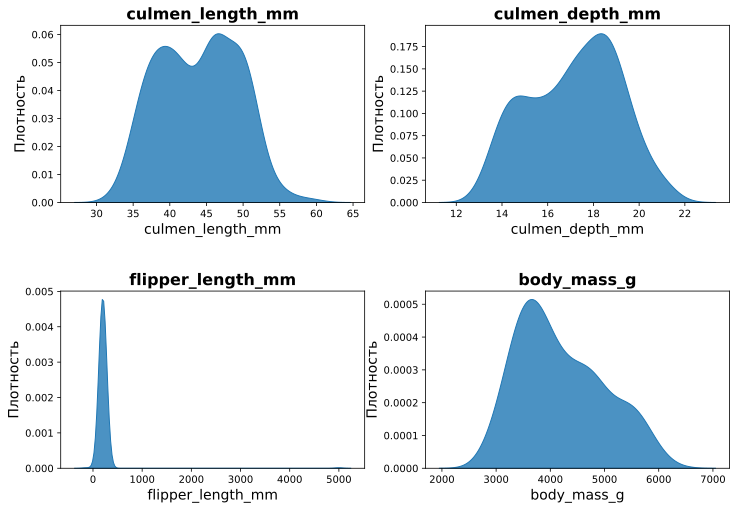

In [23]:
DataSetLib.show_density_plots(dataset_df[params["num_columns"]], params["num_columns"])

<Axes: ylabel='count'>

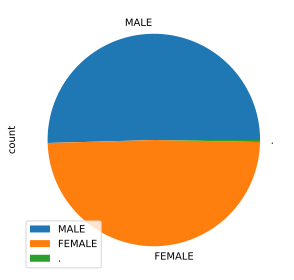

In [24]:
# распределение по классам
pd.DataFrame(dataset_df["sex"].value_counts()).plot.pie(y='count')

Можно сделать следующие выводы:
1. Небольшое количество строк содержит пропуски в данных. Судя по одинаковой доле пустых значений в каждом строке - это какие-то пустые строки в наборе данных.
2. В столбце sex тоже есть есть пропуски и невалидные значения
3. Диапазоны значений в столбцах заметно отличаются - нужна будет нормализация
4. В столбце flipper_length_mm скорее всего есть выборы - слишком длинный правых хвост в графике распределения плотности значений
5. В столбцах culmen_length_mm и culmen_depth_mm есть два горба в графике распределения плотноси. Предоложительно это имеет определенную связь с двумя классами - male и female
6. Распределение классов равномерное

# Подготовка датасета

### Обработка пропусков пропусков 

In [25]:
# Строки, в которых есть пустые числовые столбцы
rows_with_all_columns_nan, all_rows_with_nan = DataSetLib.find_rows_with_nan(dataset_df, params["num_columns"])
dataset_df.iloc[all_rows_with_nan]

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
339,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN


Какая-то ошибка в датасете - удалим эти строки

In [26]:
dataset_df.drop(dataset_df.iloc[rows_with_all_columns_nan].index, inplace=True)
dataset_df.reset_index(inplace=True, drop=True)

In [27]:
# Строки, в которых есть пропуски в категориальных столбцах
rows_with_all_columns_nan, all_rows_with_nan = DataSetLib.find_rows_with_nan(dataset_df, params["columns_X"])
dataset_df.iloc[all_rows_with_nan]

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
323,47.30000,13.80000,216.00000,4725.00000,NaN
7,34.10000,18.10000,193.00000,3475.00000,NaN
9,37.80000,17.10000,186.00000,3300.00000,NaN
10,37.80000,17.30000,180.00000,3700.00000,NaN
46,37.50000,18.90000,179.00000,2975.00000,NaN
245,44.50000,14.30000,216.00000,4100.00000,NaN
285,46.20000,14.40000,214.00000,4650.00000,NaN


Строк с пропусками немного. Можно было бы заменить на моду, но когда всего два класса с практически одинаковым количеством - это может внести искажения в данные.
Извлечем эти строки в отдельный датасет - будет интересно прогнать на нем модель кластеризации.

In [28]:
rows_with_all_columns_nan

[7, 9, 10, 46, 245, 285, 323]

In [29]:
dataset_df_nan_sex = dataset_df.loc[rows_with_all_columns_nan, ]
dataset_df_nan_sex

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
7,34.10000,18.10000,193.00000,3475.00000,NaN
9,37.80000,17.10000,186.00000,3300.00000,NaN
10,37.80000,17.30000,180.00000,3700.00000,NaN
46,37.50000,18.90000,179.00000,2975.00000,NaN
245,44.50000,14.30000,216.00000,4100.00000,NaN
285,46.20000,14.40000,214.00000,4650.00000,NaN
323,47.30000,13.80000,216.00000,4725.00000,NaN


In [30]:
dataset_df.drop(dataset_df.iloc[rows_with_all_columns_nan].index, inplace=True)
dataset_df.reset_index(inplace=True, drop=True)

In [31]:
# Проверим датасет на наличие остатков строк с пропусками
# Строки, в которых есть пустые числовые столбцы
rows_with_all_columns_nan, all_rows_with_nan = DataSetLib.find_rows_with_nan(dataset_df, params["num_columns"])
dataset_df.iloc[all_rows_with_nan]

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex


## Изучим на предмет выбросов

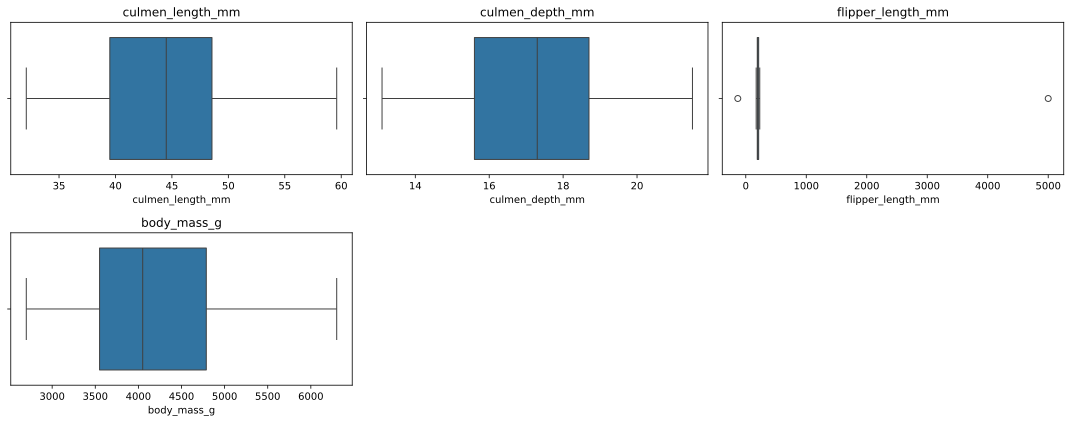

In [32]:
DataSetLib.show_boxes_plt(dataset_df.dropna(), params["num_columns"])

Выбросы только в столбце flipper_length_mm. Посмотрим на эти строки внимательнее

In [33]:
_, _, _, lower, upper = DataSetLib.iqr_values(dataset_df.dropna()["flipper_length_mm"])
print(f'Нижняя граница: {lower}')
print(f'Верхняя граница: {upper}')
display(dataset_df[(dataset_df["flipper_length_mm"]<lower) | (dataset_df["flipper_length_mm"]>upper)])

Нижняя граница: 155.5
Верхняя граница: 247.5


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
7,42.00000,20.20000,5000.00000,4250.00000,MALE
10,34.60000,21.10000,-132.00000,4400.00000,MALE


Явные выбросы, точнее неправильные значения. Заменим на медиану, но в рамках своего класса.

In [34]:
dataset_df.loc[((dataset_df["flipper_length_mm"]<lower) | (dataset_df["flipper_length_mm"]>upper)) & \
               (dataset_df["sex"]=='MALE'), 
               "flipper_length_mm"] = dataset_df[dataset_df["sex"]=='MALE']["flipper_length_mm"].median()

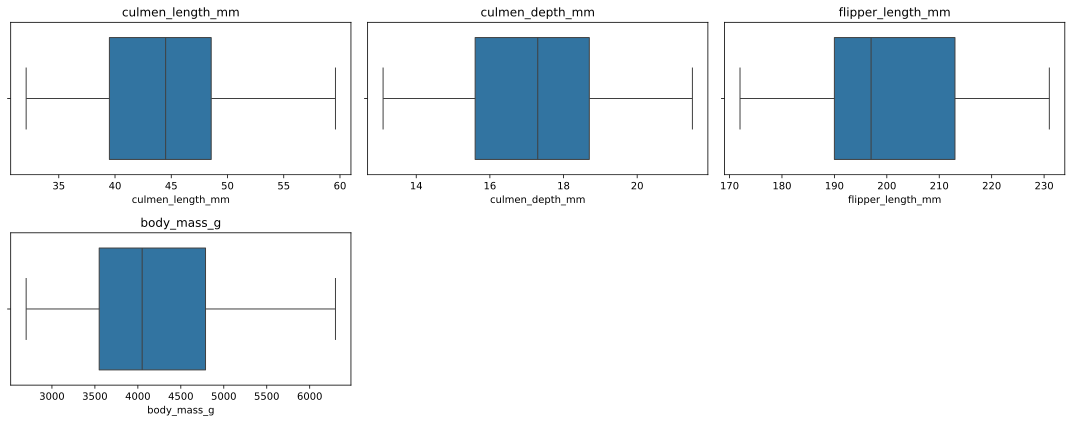

In [35]:
DataSetLib.show_boxes_plt(dataset_df.dropna(), params["num_columns"])

Выбросы не осталось

## Корреляция между столбцами

In [36]:
fig = plotly_px.imshow(dataset_df[params["num_columns"]].corr(), height=1000, width=1000, text_auto='.2f' )
fig.show()

Между flipper_length_mm и body_mass_g заметный коэффициент корреляции - 0.87.
Можно было бы удалить один из признаков, но у нас их всего 4 - оставим.

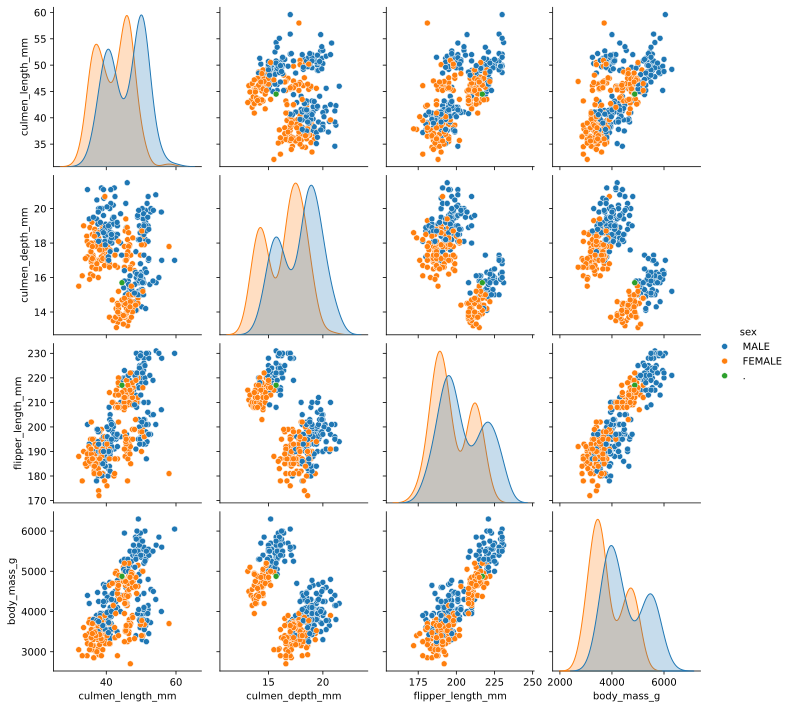

In [37]:
sns.pairplot(dataset_df, hue='sex');# Корреляция между столбцами

## Анализ категориальных столбцов

In [38]:
print("Уникальные значения по столбцам")
nunique = dataset_df[params["cat_columns"]].nunique()
for column in nunique.index:
    if nunique[column] <= 10:
        print(f'{column:20}: {nunique[column]:6}, {dataset_df[column].unique().tolist()}')
    else:
        print(f'{column:20}: {nunique[column]:6}')
    display(dataset_df[column].value_counts())

Уникальные значения по столбцам
sex                 :      3, ['MALE', 'FEMALE', '.']


sex
MALE      169
FEMALE    165
.           1
Name: count, dtype: int64

In [42]:
# Есть одно некорректное значение. Посмотрим на эту строки
rows_with_wrong_sex = dataset_df.loc[((dataset_df['sex']!='MALE') & (dataset_df['sex']!='FEMALE')), ].index.to_list()
dataset_df.iloc[rows_with_wrong_sex]

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
328,44.50000,15.70000,217.00000,4875.00000,.


Поступим также, как с пропусками - извлечем в отдельный датасет

In [43]:
dataset_df_nan_sex = pd.concat([dataset_df_nan_sex, dataset_df.iloc[rows_with_wrong_sex]], axis=0)
dataset_df_nan_sex

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
7,34.10000,18.10000,193.00000,3475.00000,NaN
9,37.80000,17.10000,186.00000,3300.00000,NaN
10,37.80000,17.30000,180.00000,3700.00000,NaN
46,37.50000,18.90000,179.00000,2975.00000,NaN
245,44.50000,14.30000,216.00000,4100.00000,NaN
285,46.20000,14.40000,214.00000,4650.00000,NaN
323,47.30000,13.80000,216.00000,4725.00000,NaN
328,44.50000,15.70000,217.00000,4875.00000,.
328,44.50000,15.70000,217.00000,4875.00000,.


In [45]:
dataset_df.drop(dataset_df.iloc[rows_with_wrong_sex].index, inplace=True)
dataset_df.reset_index(inplace=True, drop=True)

In [46]:
# Проверить на наличие некорректных значений
dataset_df.loc[(dataset_df['sex']!='MALE') & (dataset_df['sex']!='FEMALE')]

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex


## Финальный обзор датасета

In [47]:
params = DataSetLib.columns_by_type(dataset_df, None)
DataSetLib.describe_columns(dataset_df, params)

Количество уникальных значений по столбцам, доля пропусков и уникальные значения, если их не более 10
culmen_length_mm    [n]:    162        
culmen_depth_mm     [n]:     80        
flipper_length_mm   [n]:     54        
body_mass_g         [n]:     93        
sex                 [c]:      2        , ['MALE', 'FEMALE']


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,333.00000,333.00000,333.00000,333.00000
mean,43.97237,17.17688,200.91291,4201.80180
std,5.46336,1.97552,13.96709,799.16686
min,32.10000,13.10000,172.00000,2700.00000
10%,36.60000,14.32000,185.00000,3300.00000
25%,39.50000,15.60000,190.00000,3550.00000
50%,44.40000,17.30000,197.00000,4050.00000
75%,48.50000,18.70000,213.00000,4750.00000
90%,50.80000,19.58000,220.80000,5400.00000
max,59.60000,21.50000,231.00000,6300.00000


,sex
count,333
unique,2
top,MALE
freq,168


Пропусков нет, значения корректные.

## Нормализовать данные

In [49]:
from sklearn.preprocessing import StandardScaler
dataset_df_not_scaled = dataset_df[params["num_columns"]]
dataset_df_StandardScaler = StandardScaler().fit_transform(dataset_df[params["num_columns"]])

## Перекодировать категориальный столбец класса

In [ ]:
from sklearn.preprocessing import LabelEncoder
dataset_df["sex"] = LabelEncoder().fit_transform(dataset_df["sex"])

In [60]:
dataset_df

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.10000,18.70000,181.00000,3750.00000,1
1,39.50000,17.40000,186.00000,3800.00000,0
2,40.30000,18.00000,195.00000,3250.00000,0
3,36.70000,19.30000,193.00000,3450.00000,0
4,39.30000,20.60000,190.00000,3650.00000,1
...,...,...,...,...,...
328,47.20000,13.70000,214.00000,4925.00000,0
329,46.80000,14.30000,215.00000,4850.00000,0
330,50.40000,15.70000,222.00000,5750.00000,1
331,45.20000,14.80000,212.00000,5200.00000,0


# Финальный обзор датасете, подготовленного для модели

In [61]:
display(dataset_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   333 non-null    float64
 1   culmen_depth_mm    333 non-null    float64
 2   flipper_length_mm  333 non-null    float64
 3   body_mass_g        333 non-null    float64
 4   sex                333 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 13.1 KB


None

In [62]:
dataset_df.describe(include='all')

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,333.00000,333.00000,333.00000,333.00000,333.00000
mean,43.97237,17.17688,200.91291,4201.80180,0.50450
std,5.46336,1.97552,13.96709,799.16686,0.50073
min,32.10000,13.10000,172.00000,2700.00000,0.00000
25%,39.50000,15.60000,190.00000,3550.00000,0.00000
50%,44.40000,17.30000,197.00000,4050.00000,1.00000
75%,48.50000,18.70000,213.00000,4750.00000,1.00000
max,59.60000,21.50000,231.00000,6300.00000,1.00000


In [64]:
display(dataset_df.sample(7, random_state=settings.enviroment["RANDOM_STATE"]))

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
25,40.50000,18.90000,180.00000,3950.00000,1
309,49.40000,15.80000,216.00000,4925.00000,1
73,36.20000,16.10000,187.00000,3550.00000,0
195,51.50000,18.70000,187.00000,3250.00000,1
57,37.60000,17.00000,185.00000,3600.00000,0
296,50.00000,15.90000,224.00000,5350.00000,1
281,43.50000,14.20000,220.00000,4700.00000,0


In [65]:
params = DataSetLib.columns_by_type(dataset_df, None)
DataSetLib.describe_columns(dataset_df, params)

Количество уникальных значений по столбцам, доля пропусков и уникальные значения, если их не более 10
culmen_length_mm    [n]:    162        
culmen_depth_mm     [n]:     80        
flipper_length_mm   [n]:     54        
body_mass_g         [n]:     93        
sex                 [c]:      2        , [1, 0]


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,333.00000,333.00000,333.00000,333.00000
mean,43.97237,17.17688,200.91291,4201.80180
std,5.46336,1.97552,13.96709,799.16686
min,32.10000,13.10000,172.00000,2700.00000
10%,36.60000,14.32000,185.00000,3300.00000
25%,39.50000,15.60000,190.00000,3550.00000
50%,44.40000,17.30000,197.00000,4050.00000
75%,48.50000,18.70000,213.00000,4750.00000
90%,50.80000,19.58000,220.80000,5400.00000
max,59.60000,21.50000,231.00000,6300.00000


,sex
count,333.00000
mean,0.50450
std,0.50073
min,0.00000
25%,0.00000
50%,1.00000
75%,1.00000
max,1.00000


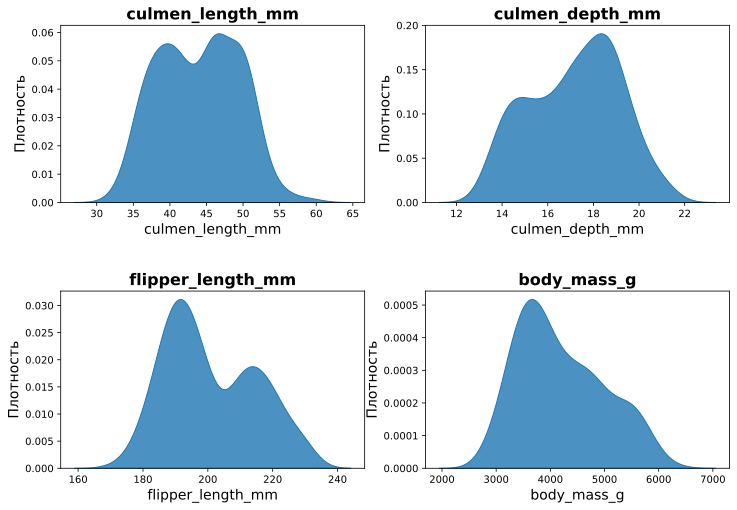

In [66]:
DataSetLib.show_density_plots(dataset_df[params["num_columns"]], params["num_columns"])

<Axes: ylabel='count'>

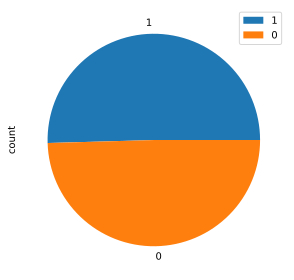

In [ ]:
# распределение по классам
pd.DataFrame(dataset_df["sex"].value_counts()).plot.pie(y='count')

# KMeans Clustering

3) Примените метод кластеризации KMeans с подбором гиперпараметров в
цикле.
4) Оцените качество кластеризации методом локтя. Сделайте вывод.
5) Оцените качество кластеризации методом силуэта. Сделайте вывод.
6) Визуализируйте кластеры и центры кластеров. Обратите внимание, что
для отображения на графике может понадобиться метод снижения
размерности.

In [75]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

In [ ]:
def draw_reduced_data(reduced_data, title, dataset):
    # Построение графика
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_data[:, 0], 
                reduced_data[:, 1], 
                c=[sns.color_palette()[x] for x in dataset.sex.map({"MALE":0, "FEMALE":1})], 
                edgecolor='k', s=50)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

    После стандартизации признаков построим модель иерархической кластеризации и выведем дендрограмму, чтобы визуализировать какое количество классов лучше брать 
    
    Иерархическую кластеризацию не будем использовать в качестве основной, с ее помощью мы просто посмотрим количество кластеров и посомтрим какие объекты и как объединяются (какие объекты схожи)

    далее мы построим алгоритм k-means, чтобы сравнить результаты работы модели и выбрать лучшую модель (мы так же будем строить DBSCAN, который тоже будет участвовать в сравнительном анализе моделей кластеризации 

### Как работает k-means

    1. Выбираются случайно n кластеров (то есть количество кластеров, которые определяются заранее)
    2. Затем берутся начальные центроиды (количество центроидов равно количеству кластеров, который обозначает пользователь) и эти точки ставяться рандомно 
    3. Группируются начальные точки, относительно расстояния от центроида до каждой точки (то есть как группируются начальные точки. Вычисляется значение от точки до каждого центроида и объект относится к тому кластеру, к которому он ближе (до центроида которого расстояние минимальное относительно других расстояний до других центроидов)
    4. Считается среднее значение в каждом кластере и повторно группируются кластеры на основе средних значений (центроиды теперь это средние значения)
    5. Повторяется до тех пор, пока кластеры не станут меняться 
    
    Когда данные сгруппированы мы смотрим на дисперсию (разброс значений вокруг среднего) внутри каждого кластера, а затем проделываем тоже самое с другими начальными точками
    Алгоритм возвращает столько вариантов кластеризации, сколько пользователь ему обозначает, а потом выбирает лучший вариант из всех

### Выбор оптимального значения количества кластеров (гиперпараметр k)

    Чтобы выбрать оптимальное значение k (количество кластеров) надо что бы в каждом кластере была наименьшая дисперсия (то есть сумма квадратов расстояний между центроидом и объектом должна стремиться к минимуму). В kmeans за эту метрику отвечает inertia которая как раз и измеряет сумму квадратов расстояний между центроидом и объектом каждого кластера 

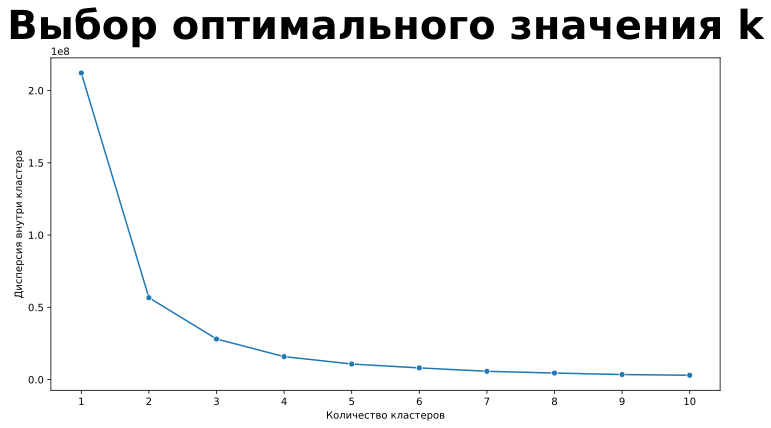

In [71]:
# Список для записи дисперсии
inertia_score = []

# Тренировка модели кластеризации с разным параметром k 
for k in range(1,11):
    kmeans = KMeans(n_clusters = k,
                    n_init = 10,
                    random_state = 42)
    kmeans.fit(dataset_df)
    inertia_score.append(kmeans.inertia_)
    
# Построение графика    
fig = plt.subplots(figsize = (12,6))
sns.lineplot(x = range(1,11),
             y = inertia_score,
             marker = 'o')
plt.title('Выбор оптимального значения k', fontsize = 40, fontweight = 'bold')
plt.xlabel('Количество кластеров')
plt.ylabel('Дисперсия внутри кластера')
plt.xticks(range(1,11))

plt.show()

    После поcтроения данного графика можно скзаать что лучше разделять данный набор данных на 3 кластера (+ так же можно обратиться к дендрограмме, которая тоже показывает, что делить лучше на 3 кластера, поэтому так как мы ориентировались на деньдрограмму издесь тоже существует явное уменьшение дисперсии внутри кластера при значениях 1 2 и 3, а дальшедисперсия уменьшается незначительно (то есть маленькими шагами)
    Следоватьельно здесь мы тоже будем использовать в качетсве гиперпараметра k(количество кластеров) значение = 3

### Построение модели KMeans

In [108]:
kmeans = KMeans(n_clusters = 4,
                n_init = 10,
                algorithm = 'elkan')

kmeans.fit(dataset_df)

KMeans(algorithm='elkan', n_clusters=4, n_init=10)

     Гиперпараметры:
     algorithm = 'elkan' - метрика оценки расстояния - Евклидово расстояния
     n_init = 10 - количество сколько раз строится кластеризация (количество начальных положений центроидов)
     n_clusters = 3 - количество кластеров = 3

In [109]:
kmeans.n_clusters

4

In [110]:
# Метки класстеров
labels = kmeans.labels_
print(labels)

# Центроиды для каждого кластера
centroids = kmeans.cluster_centers_
print(centroids)



[0 0 3 3 0 3 1 0 3 0 1 0 3 1 3 0 3 3 0 0 0 0 3 3 3 0 3 0 3 0 3 0 0 3 3 1 3
 0 3 1 3 1 3 3 0 3 0 3 0 3 0 3 0 3 0 3 1 3 0 3 0 3 0 3 1 3 0 3 0 0 0 0 0 3
 0 3 1 0 0 3 3 0 3 0 3 3 0 3 1 3 0 0 1 3 0 0 1 3 0 3 3 0 0 3 1 0 1 3 0 0 0
 3 0 3 3 3 3 3 0 3 0 3 0 3 0 3 3 3 1 3 0 3 0 3 0 3 3 3 0 3 0 0 3 3 0 0 0 3
 0 0 3 0 0 3 0 0 0 0 0 0 0 3 0 3 0 3 1 3 3 3 0 3 0 3 0 0 1 3 0 3 0 3 0 0 1
 3 1 0 0 3 3 0 1 3 0 3 0 3 0 3 0 3 3 3 0 0 3 0 0 0 0 3 0 0 0 1 2 1 2 2 1 1
 2 1 2 1 2 1 2 0 2 0 2 1 2 2 1 1 1 1 1 2 1 2 2 1 1 2 2 2 1 2 1 2 0 2 0 1 2
 1 0 2 1 2 1 2 1 1 1 1 0 1 1 2 0 2 1 2 1 2 2 1 2 1 1 1 2 1 2 1 2 1 2 1 2 1
 2 1 2 1 2 1 2 1 2 1 2 1 2 1 1 1 2 1 2 1 2 2 1 2 1 2 1 2 1 2 1 2 1 1 2 2 2]
[[4.35560748e+01 1.84504673e+01 1.95196262e+02 3.93925234e+03
  6.82242991e-01]
 [4.53168831e+01 1.57324675e+01 2.09519481e+02 4.70649351e+03
  3.76623377e-01]
 [4.96907407e+01 1.57166667e+01 2.21703704e+02 5.53981481e+03
  9.44444444e-01]
 [4.01010526e+01 1.77431579e+01 1.88557895e+02 3.32789474e+03
  1.57894737e-01]]


### Метрика kmeans

In [111]:
silhouette = silhouette_score(dataset_df, labels)
chi = calinski_harabasz_score(dataset_df, labels)
print('Силуэт', round(silhouette,3))
print('Variance Rarion Criterion', round(chi,3))

Силуэт 0.552
Variance Rarion Criterion 1358.3


    Лучше всего сработал алгоритм KMeans - следовательно присвоим каждому объекту метки рузальтата алгоритма KMeans и проанализируем каждый кластер и выделим его основные свойства и отличия 

In [117]:
dataset_df.columns[column1]

'culmen_depth_mm'

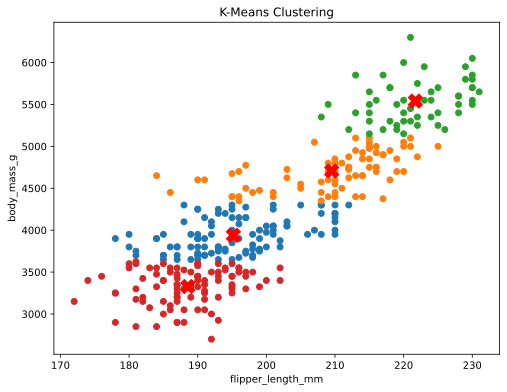

In [128]:
# Визуализация данных и центров кластеров
plt.figure(figsize=(8, 6))
column1, column2 = 2, 3
# Визуализируем данные по кластерам
for i in range(kmeans.n_clusters):
    plt.scatter(dataset_df.iloc[labels == i, column1], dataset_df.iloc[labels == i, column2])
# Визуализируем центры кластеров
plt.scatter(centroids[:, column1], centroids[:, column2], marker='X', s=200, color='red')
plt.xlabel(dataset_df.columns[column1])
plt.ylabel(dataset_df.columns[column2])
plt.title('K-Means Clustering')
plt.show()

# 6. Сравнение метрик

In [ ]:
#stat = ModelWrapBase.compare_metrcis([rfr_model_wrap, rfr_fe_model])
#stat

Обе модели показывают плохие результаты - r2_score близка к 0. Использовать для предсказания нельзя.